# Sentiment analysis with python for IMDB movie database

First, we download data from the page http://ai.stanford.edu/~amaas/data/sentiment/. In this case, the database was already downloaded, so we went straigth to put the .txt files into one single file with .csv extension so it will be easier to read it:

Primero, descargamos la base de datos de la página http://ai.stanford.edu/~amaas/data/sentiment/. En este caso, la base de datos se descargó previamente, por lo que nos fuimos directamente a contener todos los archivos con extensión .txt en un solo archivo .csv para que sea mas facil leerlo:

In [74]:
import pyprind
import pandas as pd
import os
import numpy as np

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()

df.columns = ['review', 'sentiment']

np.random.seed(0)

df = df.reindex(np.random.permutation(df.index))
df.to_csv('IMDb_Reviews.csv', index=False, encoding='utf-8')


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:13


It's important to mention that during this "grouping" process we tagged from once the positive reviews as 1 and the negative ones as 0, si it will be easier to use this futher along. Besides, we added a column in which we can define this sentiment value and "give a score" so it will be faster to tag this and work this data out during the whole process.

Es importante mencionar que durante este "agrupamiento" de los datos le asignamos un valor inicial a la columna de sentimientos de la forma: review positivo:1, review negativo:0, de tal forma que nos podamos ahorrar un poco de tiempo más adelante. Además, añadimos una columna extra a la derecha donde se le está asignando un valor 0 o 1 a cada review para que sea más sencilla su identificación durante todo el proceso. 

Now, we load all the packages we'll use. 

Ahora, cargamos todos los paquetes que vamos a usar. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

We load the database we put together before, called "IMDB_Reviews.csv"; our variable will be called imdb_data. Then, we check the shape and the first 5 data to have an idea of how it looks like:

Cargamos la base de datos que organizamos en un solo archivo .csv previamente (y que se llama "IMDB_Reviews.csv", mientras que nuestra variable inicial se llamará imdb_data. Luego, revisamos el tamaño del archivo y que la cantidad de elementos sea la esperada para comenzar a trabajar con nuestra base. Para esto, revisamos solo los primeros 5 datos:

In [2]:
imdb_data=pd.read_csv('IMDB_Reviews.csv')
print(imdb_data.shape)
imdb_data.head(5)

(50000, 2)


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


Now... is it well distributed?

Y bueno... está bien distribuída?

In [3]:
imdb_data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

As we can see, the distribution is perfect: we have the same amount of data describing positive commentaries and the negative ones.

Como podemos ver, la distribución de la información es perfecta: tenemos la misma cantidad de datos describiendo a los reviews positivos y los negativos, y están distribuídos de manera equitativa.

Before we start with the modeling part, we need first to define the size of our sets. The first thing we need to do is separate our data into the training (train) and the test set; let us remember first that we're working with 2 kind of data: the data that will give us the insight of the sentiments (the sentiment column) and the data that is related to that one (the reviews columns). We'll divide both sets the same way: 40,000 for train and 10,000 for test (this is, the classic 80-20 for ML models), giving us a total of 50,000, the original data.

Antes de comenzar a realizar el modelado, primero necesitamos definir el tamaño de nuestros conjuntos de datos. La primera cosa que necesitamos haer es separar nuestra información en el conjunto de entrenamiento (train) y el de prueba (test); como en este caso estamos trabajando con dos tipos de información, esto es, la información que nos da los sentimientos y que es binaria y la información que nos describe a los reviews, vamos a dividir esta información de manera equitativa entre los dos conjuntos como: 40,000 para entrenamiento y 10,000 para prueba (esto es, la distrubución clásica en los modelos de machine learning), lo que nos da un total de 50,000 datos, la cantidad original.

In [79]:
#datos para train
train_reviews=imdb_data.review[:40000]
#desde el inicio hasta el 40000
train_sentiments=imdb_data.sentiment[:40000]
#del 40000 en adelante

#datos para test
test_reviews=imdb_data.review[40000:]
#desde el inicio hasta el 40000
test_sentiments=imdb_data.sentiment[40000:]
#desde el inicio hasta el 40000

#vemos como estan distribuidos mis datos
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


The next step is to clean up the data. First, we'll begin by removing the html content, the brackets and the noise text like, for examplie, spaces between the letters. 

El siguiente paso es limpiar la información antes de meterla al modelo. Para esto, primero necesitamos remover contenido como los tags de html, los paréntesis y los espacios en blanco.

In [80]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#aplicamos esto a mi set review, que es el que me interesa
imdb_data['review']=imdb_data['review'].apply(denoise_text)

 Now, we remove the special characters. 
 
 Ahora, removemos los caracteres especiales. 

In [81]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#aplicamos esto a mi set review, que es el que me interesa
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

Now, we need to remove the stopwords (this is, the words that go between two ideas and connect them), because these ones dont really have a sentiment and can affect the final result. For this, which we'll take the nltk module to tell python which words are the stop words, and this will be easy for the module since we're working with a database in english:

Ahora vamos a remover las stopwords (esto es, las palabras que se encuentran dentro de los enunciados y que se encargan de unir dos diferentes ideas y que, al no tener una clasificación real positiva o negativa, pueden afectar nuestro resultado final). Para esto, vamos a usar el módulo nitk para decirle a python cuáles con las stopwords más comunes, lo cual será sencillo ya que la mayor cantidad de soporte de este tipo de trabajos se encuentra en inglés y nuestra base se conforma completamente de reviews en inglés:

In [82]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
rev = imdb_data['review']
rev = [word for word in rev if not word in set(stopwords.words('english'))]
rev

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anapaolahernandezgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['My family and I normally do not watch local movies for the simple reason that they are poorly made they lack the depth and just not worth our timeThe trailer of Nasaan ka man caught my attention my daughter in laws and daughters so we took time out to watch it this afternoon The movie exceeded our expectations The cinematography was very good the story beautiful and the acting awesome Jericho Rosales was really very good sos Claudine Barretto The fact that I despised Diether Ocampo proves he was effective at his role I have never been this touched moved and affected by a local movie before Imagine a cynic like me dabbing my eyes at the end of the movie Congratulations to Star Cinema Way to go Jericho and Claudine',
 'Believe it or not this was at one time the worst movie I had ever seen Since that time I have seen many more movies that are worse how is it possible Therefore to be fair I had to give this movie a 2 out of 10 But it was a tough call',
 'After some internet surfing I fou

Now, we need to normalize our data. For that, we'll use lemmatizer from nltk to recognize the words, since it's the method that will probably give us the better results:

Ahora, necesitamos normaizar nuestros datos. Para esto, vamos a usar el módulo de nltk para reconocer las palabras, ya que este es el método que probablemente nos de los mejores resultados:

In [83]:
import nltk
nltk.download('wordnet')

def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

imdb_data['review'] = get_lemmatized_text(imdb_data['review'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anapaolahernandezgonzalez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


It's important to say that we tried first with the stemmed model but the results were poor compared to these ones, so we decided to stick up with these.

Es importante mencionar que intentamos primero con el método de stemmed pero los resultados fueron bastante pobres comparados con los resultados obtenidos con este método, para el cual el reconocimiento de texto es mucho mejor, por lo que nos quedamos al final con este método de Lemmatizer.

How's my data looking now?

Cómo se ven mis datos ahora?

In [84]:
imdb_data['review']

0        My family and I normally do not watch local mo...
1        Believe it or not this wa at one time the wors...
2        After some internet surfing I found the Homefr...
3        One of the most unheralded great work of anima...
4        It wa the Sixties and anyone with long hair an...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable this in turn mak...
49997    So there this bride you see and she get crushe...
49998    Your mind will not be satisfied by this nobudg...
49999    The chaser war on everything is a weekly show ...
Name: review, Length: 50000, dtype: object

Now, we'll need to vectorize our data. The vectorization is used to convert text documents to numerical vectors. In this case, we'll use the "bag of words" model

Ahora, vamos a vectorizar nuestra información. La vectorización es la asignación de valores numéricos a documentos de texto, lo que nos va a ayudar a colocar nuesta información en el modelo final. Para la vectorización usamos un modelo llamado "Bag of Words"

In [85]:
norm_train_reviews=imdb_data.review[:40000]
norm_test_reviews=imdb_data.review[40000:]

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#ajuste a train reviews, ya vectorizados 
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#ajuste a test reviews, ya vectorizados
cv_test_reviews=cv.transform(norm_test_reviews)

#como se distribuyen ahora mis datos?
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)


BOW_cv_train: (40000, 6408265)
BOW_cv_test: (10000, 6408265)


Everything we've done so far has been to manipulate information from the reviews column. Right now, we'll also transform the label into info that can be useful for me (this is, the sentiment column)

Todo lo que hemos hecho hasta el momento ha sido para manipular la informacion de los reviews. Es momento de transformar tambien el label (esto es, la columna de sentimiento)

In [87]:
lb=LabelBinarizer()
#ajuste a sentiment, ya vectorizado
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [4]:
Is my info still now vectorized?

Ya se vectorizó mi información?

Object `vectorized` not found.
Object `información` not found.


In [88]:
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]
[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


This is it, the moment we´ve been waiting for. The moment where we can apply all the technics and models to check and see if we can predict/adjust our data in order to know which one of the words are the ones that are more likely to find, which ones have a bigger weigth and if it´s the negative or the positive words (this is, if the negative or positive reviews) have a bigger importance in the whole of the database. To do this, we´ll began with a Linear Logistic Regresion model in order to have the option to maybe being able to classify or maybe even predict classification, so it´s a good way to start.

Ahora sí, este es el momento interesante. El momento de la verdad: aplicar los modelos correspondientes para ver si podemos predecir/ajustar nuestros datos para saber cuáles son las palabras que más se repiten y si tienen un mayor peso las palabras negativas o las positivas (esto es, si los reviews positivos o los negativos tienen más peso e importancia). Para esto, vamos a comenzar con un modelo de regresión logistica lineal, ya que este tipo de modelos nos pueden dar tanto predicciones como clasificaciones, por lo que es un buen punto para comenzar.

In [89]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Ajustamos el modelo Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#FAjustamos el modelo para tfidf
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Now, what´s the tfidf model? the tfidf (Term frequency-inverse document frequency) model is an iteration derived from the BOW model that counts all words in the review and then inside each document using numerical methods, therefore it has to give us in theory a very more precise result than the BOW model, so we´re trying both and comparing them between each other. 

Pero, qué es el modelo tfidf? el modelo tfidf (Term frequency-inverse document frequency) es una iteración derivada del modelo de BOW que cuenta todas las palabras dentro de un review y luego dentro de cada docmuento usando métodos numéicos, por lo que en teoría tiene que darnos una precisión mucho mayor que el modelo de BOW, por lo que vamos a comparar ambos modelos entre ellos para ver el rendimiento de ambos.

In [90]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
#Predecimos el modelo para las caracteriticas del modelo tfidf
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 1 ... 0 0 1]
[0 0 1 ... 0 0 1]


In [91]:
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score para el modelo tfidf 
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7557
lr_tfidf_score : 0.7559


In [92]:
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)
#aqui le decimos al modelo que debe clasificar los datos de sentiment como positivos y negativos

#Classification report para el modelo tfidf 
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

#Qué tanto acertó ami modelo a la clasificación de positivo y negativo?

              precision    recall  f1-score   support

    Positive       0.76      0.75      0.75      5013
    Negative       0.75      0.76      0.76      4987

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

              precision    recall  f1-score   support

    Positive       0.76      0.76      0.76      5013
    Negative       0.76      0.75      0.76      4987

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [93]:
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix para el modelo tfidf 
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3796 1191]
 [1252 3761]]
[[3763 1224]
 [1217 3796]]


As we can see, our model didn´t quite do the trick, because the accuracy score is actually low, and the confusion matrix has several mistakes, which means the logistic regresion method migth not be the best one for this.

Como podemos ver, el modelo no funcionó de manera completamente adecuada, porque el accuracy score fue reealmente bajo, y la matruz de confusión tiene varios errores, lo que significa que la regresión logística probablemente no era la mejor opción para este problema.

But... how can I know which of the words are the most important ones? to see this more graphycally, we can take a word cloud for both the positive and the negative reviews

Pero... cómo puedo saber cuáles de las palabras fueron las más importantes o usadas? para poder ver esto de forma gráfica, podemos tomar un word cloud tanto para las palabras positivas como para las negativas.

<function matplotlib.pyplot.show(*args, **kw)>

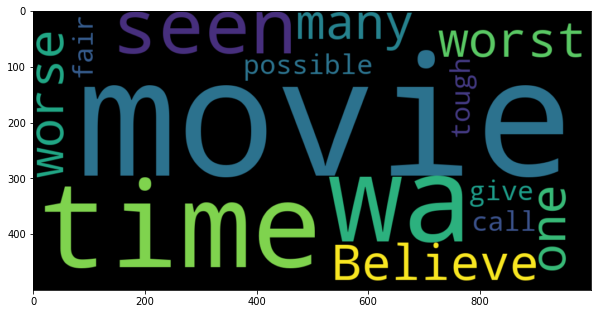

In [94]:
#word cloud para reviews positivos
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

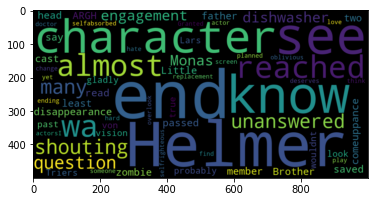

In [95]:
#word cloud para reviews negativos
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

As we can see in both cases, the words are not exactly the ones we would expect them to find in a positive review and a negative one, which means that the words that the model gave us here as the mostly used ones might not really be these ones. On the other side, it is very probable that using another prediction and classification model we can improve the accuracy score, the confusion matrix and the graphs like these one, with the word cloud. 

Como podemos ver en ambos casos, las palabras no son exactamente las que esperaríamos de un review positivo y uno negativo, lo que significa que las palabras que nos contó como las más usadas probablemente no son estas. Por otro lado, es posible que usando otro modelo de predicción y clasificación pueda mejorar tanto el accuracy score y la matriz de confusión como este tipo de gráficas del tipo word cloud. 

# Conclusiones:

1. To mahe this model we used a Logistic Regresion Lineal model that gave us an adjustment better than 70% but stil low, also giving failures in the confusion matrix.
2. The graphic representation showed us also that the model had not the best adjustment, and this was because some of the words its showing as the most important ones have no real meaning or sense, and this was because the model was not really the greatest fit.
3. For future work it is recomended to use a different model like the SVM, the Naive Bayes or even a blind classification with unclassified data with kemeans to see the difference with these results.
---
1. Para realizar este modelo se usó un modelo de regresión logística lineal que nos dio un ajuste mayor al 70%, pero no fue tan preciso en la matriz de confusión.
2. La representación gráfica nos muestra a su vez que el modelo no tuvo el mejor ajuste, debido a que algunas de las palabras que menciona como las más importantes en realidad no tienen tanto sentido.
3. Se recomienda completar este ejercicio con un modelo de SVM, de Naive Bayes o incluso una clasificación ciega con datos crudos con kmeans para ver el comparativo.